# Interface to `optikon`

This study validates and documents shortcomings of the interface provided by `optikon` for the purpose of implementing rule boosting algorithms.

(100, 2)
(100,)


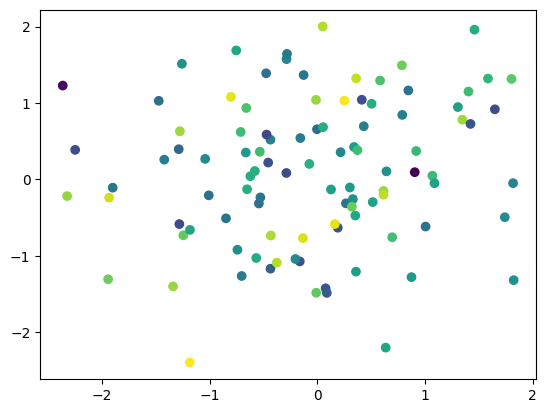

In [1]:
import numpy as np
from matplotlib import pyplot as plt

x = np.random.default_rng(seed=0).multivariate_normal([0, 0], np.eye(2), size=100)
y = np.random.default_rng(seed=0).normal(size=100)
print(x.shape)
print(y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

## Basic Calls

In [3]:
from optikon import max_weighted_support, equal_width_propositionalization

props = equal_width_propositionalization(x)
key, _, _ ,_ = max_weighted_support(x, y, props, max_depth=5)
props[key].support_all(x)

array([ 0,  4,  5,  6,  7,  8, 13, 15, 18, 22, 25, 29, 30, 32, 34, 36, 40,
       41, 46, 48, 49, 51, 52, 57, 61, 62, 64, 72, 73, 76, 77, 78, 79, 80,
       81, 83, 85, 87, 89, 90, 91, 94, 95, 96, 98])

## Integration into Regressor Class

In [42]:
class RuleBoostingRegressor:

    def __init__(self, num_rules=3, max_depth=5):
        self.num_rules = num_rules
        self.max_depth = max_depth

    def fit(self, x, y):
        n = len(x)
        props = equal_width_propositionalization(x)
        self.q_ = []

        q_matrix = np.zeros(shape=(n, self.num_rules))
        self.coef_ = np.zeros(shape=0)
        for i in range(self.num_rules):
            # this is a bit shaky in the first iteration but seems to work as intended
            # should get more robust once one adds a background rule
            y_hat = q_matrix[:, :i].dot(self.coef_) 
            g = y - y_hat

            opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, self.max_depth)
            opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, self.max_depth)
            if opt_val_pos >= opt_val_neg:
                self.q_.append(props[opt_key_pos])
            else:
                self.q_.append(props[opt_key_neg])

            q_matrix[self.q_[i].support_all(x), i] = 1
            self.coef_ = np.linalg.solve(q_matrix[:, :i+1].T.dot(q_matrix[:, :i+1]), q_matrix[:, :i+1].T.dot(y))

        return self
    
    def predict(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix.dot(self.coef_)
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} \n'
        return res
    
    def __repr__(self):
        return f'RuleBoostingRegressor({self.num_rules}, {self.max_depth})'

rb_regressor = RuleBoostingRegressor(num_rules=5).fit(x, y)
print(rb_regressor)
rb_regressor

+0.920 if x1 <= 1.394 & x2 <= 0.066 
-0.954 if x1 >= -1.291 & x2 >= -1.782 & x2 <= 0.682 
+0.328 if x1 >= -1.291 & x2 >= -1.166 
-0.548 if x1 <= 0.217 & x2 >= 0.550 
+0.872 if x1 >= -1.291 & x1 <= 0.320 & x2 >= 0.066 & x2 <= 1.298 



RuleBoostingRegressor(5, 5)